# **[Project_11_Building a Transformer Chatbot With Tensorflow]**

## **1. 데이터 불러오기 및 확인**
---

### **1-1. 라이브러리 불러오기**

In [18]:
############################################## 라이브러리 불러오기 #####################################################

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format #지수표현식말고 실수로 표현
import platform
import random
import statsmodels
import math
import warnings
warnings.filterwarnings(action = "ignore")
import missingno as msno
import scipy as sp
from scipy import stats
from scipy.stats import norm
import re
import urllib.request
import os
!pip install tabulate
import requests
from locale import Error
from tabulate import tabulate 
tabulate_df = lambda df:tabulate(df,headers= 'keys' ,tablefmt= 'psql' ) 
pd.options.display.float_format = '{:.2f}'.format # 소수점 5자리까지 표현. 바꾸기 가능


# 시각화
import seaborn as sns
sns.set(font_scale=1.5)
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams['axes.unicode_minus'] = False 
plt.style.use('seaborn')




# 모델
import tensorflow as tf
import tensorflow_datasets as tfds


# mecab 
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)





Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.l

In [19]:
############################## 데이터 정보 확인하는 클래스 생성  ##############################
data_dict = {}

pdtabulate= lambda df:tabulate(df,headers= 'keys' ,tablefmt= 'psql' ) 

class CheckData:
  def __init__(self,data_dict=data_dict):
    self.data_dict = data_dict
    self.data_keys = list(data_dict.keys())
    
  # 데이터 출력해보기
  def print_data(self):
    data_dict = self.data_dict
    data_keys = self.data_keys

    for key in data_keys:
      data = data_dict[key]
      
      print(f"\n############################## {key} 데이터 확인 ##############################\n")
      print(f' *데이터 타입 : {type(data)}')
      print(f' *데이터 크기 : {data.shape}')
      print(' *데이터 출력(랜덤 10개) \n ')
      # print(f' *데이터 출력 : {data.head(10)}')
      # 데이터컬럼 갯수가 6개이상일 경우 5개 단위로 끊어서 출력해주기 
      n = 6
      columns = list(data.columns)
      data_10 = data.sample(n=10)
      split_columns = [columns[i * n:(i + 1) * n] for i in range((len(columns) + n - 1) // n )]
      [print(tabulate_df(data_10[columns])) for columns in split_columns ]
      # print(f' *데이터 출력(랜덤 10개) \n {}')

  
  # 데이터 정보 확인하는 함수
  def print_data_info(self):
    data_dict = self.data_dict
    data_keys = self.data_keys

    for key in data_keys:
      data = data_dict[key]
      print(f"\n############################## {key} 데이터 정보확인 ##############################\n")
      try:
        # feature 결측치갯수, 데이터 타입 확인 
        print(f"\n### {key}  feature 결측치갯수, 데이터 타입 확인  ###\n")
        print(data.info(verbose=True))

      except:
        print(f"{data.name} 컬럼 타입: {data.dtypes}" )
        
      # feature 별 유일한 값 개수 확인
      print(f"\n### {key}  feature 별 유일한 값 개수 확인  ###\n")
      [print(f"{col} : {len(data[col].unique())}") for col in data]


  # 통계값 확인하는 함수
  def print_data_describe(self):
    data_dict = self.data_dict
    data_keys = self.data_keys

    for key in data_keys:
      data = data_dict[key]
      print(f"\n############################## {key} 데이터 통계확인 ##############################\n")
      # print(data.describe(include="all"))
      print(tabulate_df(data.describe(include="all")))
  
  # 결측값 확인하는 함수
  def print_missing_value(self):
    data_dict = self.data_dict
    data_keys = self.data_keys
        
    for key in data_keys:
      data = data_dict[key]
      print(f"\n############################## {key} 결측값 확인 ##############################\n")
      
      
      try:
        nan_cnt = pd.DataFrame(data=data.isnull().sum()/len(data),columns=['NaN_cnt'])
        total = data.isnull().sum().sort_values(ascending=False)
        percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        percent_data = percent.head(20)
        percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
        plt.xlabel("", fontsize = 20)
        plt.ylabel("", fontsize = 20)
        plt.title(f"{key} :Total Mbv issing Value (%)", fontsize = 20)
        print(f"\n##### {key} 컬럼별 결측값 비율 시각화 ######\n")
        plt.show()
        print(f"\n##### {key} 컬럼별 결측값 갯수 ######\n")
        print(data.isnull().sum())

      except:
        print(f"\n##### {key} 결측값 갯수: {data.isnull().sum()} 개 ######\n")
        print()




### **1-2. 데이터 불러오기**

In [72]:
############################################## 데이터 불러오기 #####################################################



urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
chatbot_data = pd.read_csv('ChatBotData.csv')

print("chatbot_data shape: ", chatbot_data.shape)
chatbot_data.head()


chatbot_data shape:  (11823, 3)


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


## **2. 데이터 탐색 및 전처리**
---

### **2-1. 데이터 탐색**

In [73]:
############################## 데이터를 data_dict 딕셔너리에 저장  ##############################
data_dict = {}
data_dict['chatbot'] = chatbot_data

In [74]:
############################## 데이터 확인 ##############################
CheckData(data_dict).print_data()


############################## chatbot 데이터 확인 ##############################

 *데이터 타입 : <class 'pandas.core.frame.DataFrame'>
 *데이터 크기 : (11823, 3)
 *데이터 출력(랜덤 10개) 
 
+-------+--------------------------------------------+--------------------------------------------------------------+---------+
|       | Q                                          | A                                                            |   label |
|-------+--------------------------------------------+--------------------------------------------------------------+---------|
|  9935 | 사랑이 정말 있을까?                        | 없어요. 일시적인 감정 교란일 뿐 아무것도 아니에요.           |       2 |
|  8514 | 헤어지고 1주에 한번은 뭐라도 오네          | 제대로 헤어지지 못했군요.                                    |       1 |
| 11139 | 좋아하는 사람이 있는데 고백하는 건 싫어요. | 구속되기 싫은 건지 생각해보세요.                             |       2 |
|  7977 | 전 헤어지고 곧장 소개팅을 했죠.            | 새로운 사람도 잊는 방법 중에 하나죠.                         |       1 |
|  7561 | 이별이란                                 

In [75]:
############################## 컬럼 타입확인 ##############################

CheckData(data_dict).print_data_info()


############################## chatbot 데이터 정보확인 ##############################


### chatbot  feature 결측치갯수, 데이터 타입 확인  ###

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB
None

### chatbot  feature 별 유일한 값 개수 확인  ###

Q : 11662
A : 7779
label : 3


In [76]:
############################## 데이터 통계값 확인 ##############################

CheckData(data_dict).print_data_describe()




############################## chatbot 데이터 통계확인 ##############################

+--------+--------+----------------+--------------+
|        | Q      | A              |        label |
|--------+--------+----------------+--------------|
| count  | 11823  | 11823          | 11823        |
| unique | 11662  | 7779           |   nan        |
| top    | 외로워 | 맛있게 드세요. |   nan        |
| freq   | 4      | 22             |   nan        |
| mean   | nan    | nan            |     0.80318  |
| std    | nan    | nan            |     0.812012 |
| min    | nan    | nan            |     0        |
| 25%    | nan    | nan            |     0        |
| 50%    | nan    | nan            |     1        |
| 75%    | nan    | nan            |     2        |
| max    | nan    | nan            |     2        |
+--------+--------+----------------+--------------+



############################## chatbot 결측값 확인 ##############################


##### chatbot 컬럼별 결측값 비율 시각화 ######



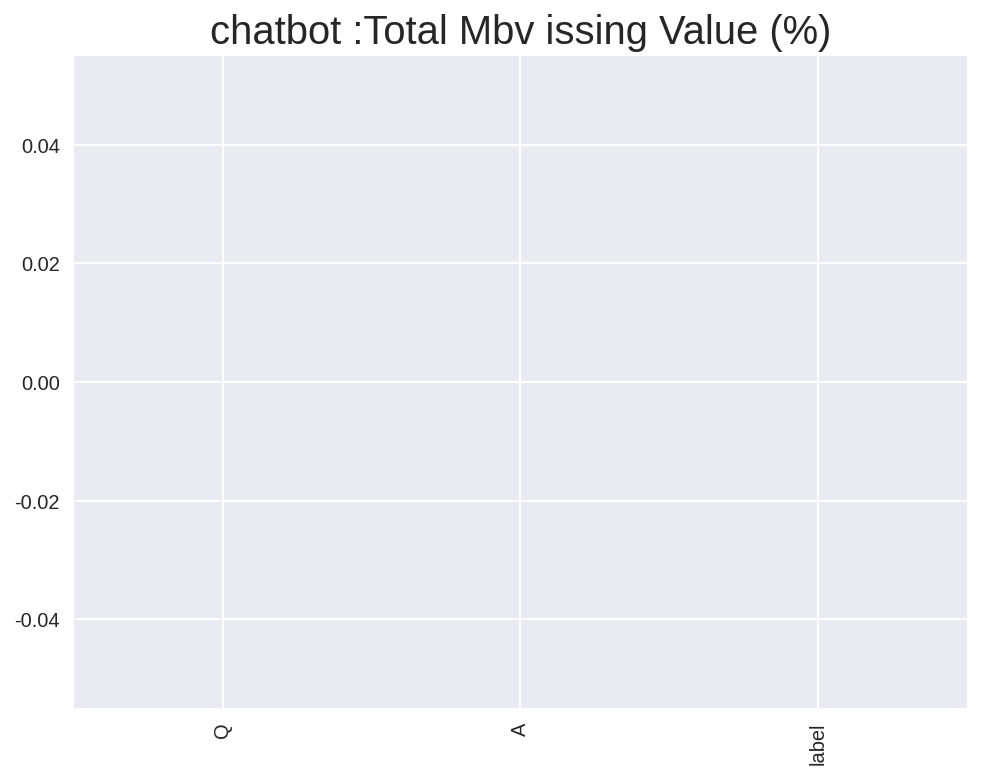


##### chatbot 컬럼별 결측값 갯수 ######

Q        0
A        0
label    0
dtype: int64


In [77]:
############################## 결측치 확인 ##############################

CheckData(data_dict).print_missing_value()




### **2-2. 정규표현식으로 전처리**

In [78]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

### **2-3. 질문과 답변의 쌍인 데이터셋 구성**

In [79]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수

def load_conversations(questions,answers):
  inputs, outputs = [], []
  
  for question, answer in zip(questions, answers):
      inputs.append(preprocess_sentence(question))
      outputs.append(preprocess_sentence(answer))
      
  return inputs, outputs


In [80]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations(chatbot_data['Q'], chatbot_data['A'])
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [81]:

print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


## **3. SubwordTextEncoder 활용한 토큰화**
---

### **3-1. 단어장(Vocabulary) 구성**

In [82]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)


# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]


In [83]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8127]
END_TOKEN의 번호 : [8128]


In [84]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8129


### **3-2.Integer Encoding & Padding**

In [85]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5742, 612, 2481, 4148]
정수 인코딩 후의 21번째 답변 샘플: [2352, 7481, 7, 6245, 97, 1]


In [86]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [87]:

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [88]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8129
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


### **3-3. 교사강요 (Teacher Forcing)**

In [89]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## **4. 모델 구현을 위한 함수, 클래스 정의**
---

### **4-1. PositionalEncoding**

In [90]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


### **4-2. Attention**

In [91]:
####################  스케일드 닷 프로덕트 어텐션 함수 정의  #######################

def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [92]:
##################### 병렬로 어텐션 수행하는 MultiHeadAttention 클래스 정의  #######################
# 내부적으로는 스케일드 닷 프로덕트 어텐션 함수를 호출
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

### **4-3. Masking**

In [93]:
##################### 패딩마스킹을 구현하는 함수 정의  #######################

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [94]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [95]:
##################### 다음 단어 가리는 Look-ahead masking 함수 정의  #######################
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - \
        tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [96]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### **4-4. Encoding**

In [97]:
###################### 인코더 층 만드는 함수 정의  #######################

# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [98]:
###################### 인코더 층을 쌓아 인코더 만드는 함수 정의  #######################

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### **4-5. Decoding**

In [99]:
###################### 디코더 층 만드는 함수 정의  #######################

# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [100]:
###################### 디코더 층을 쌓아 디코더 만드는 함수 정의  #######################
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### **4-6. Transformer**

In [101]:
###################### 트랜스포머 함수 정의  #######################
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## **5. 모델 정의 및 학습하기**
---

### **5-1. 모델 생성**

In [102]:
tf.keras.backend.clear_session()


# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율


model_1 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model_1.summary()



Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3135232     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [103]:
# tf.keras.backend.clear_session()

NUM_LAYERS = 6  # 인코더와 디코더의 층의 개수
D_MODEL = 512  # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8  # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512  # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1  # 드롭아웃의 비율

model_2 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model_2.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    13629952    ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

### **5-2. 손실함수 정의**

In [105]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### **5-3. 학습률 정의**

In [106]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

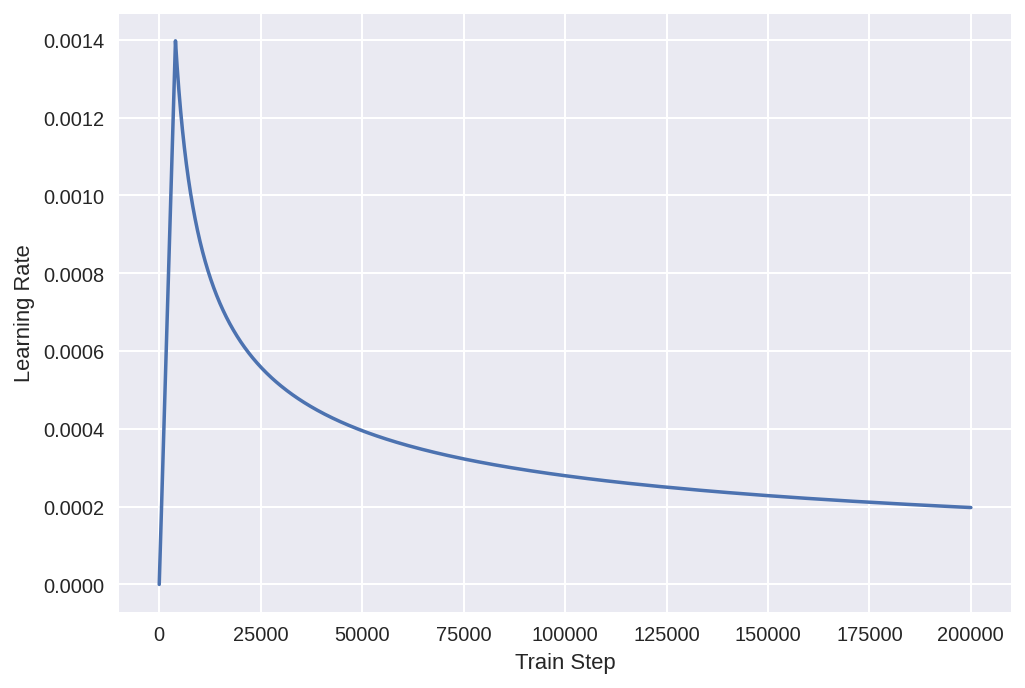

In [107]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### **5-4. 모델 컴파일**

In [108]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model_1.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model_2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### **5-5. 모델 훈련**

In [65]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
EPOCHS = 10
es = EarlyStopping(monitor='accuracy', patience=2, verbose=1)
history_1 = model_1.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[es])
history_2 = model_2.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[es])

Epoch 1/10
185/185 [==============================] - 460s 2s/step - loss: 1.4744 - accuracy: 0.0242
Epoch 2/10
185/185 [==============================] - 377s 2s/step - loss: 1.2419 - accuracy: 0.0491
Epoch 3/10
185/185 [==============================] - 374s 2s/step - loss: 1.0539 - accuracy: 0.0499
Epoch 4/10
185/185 [==============================] - 377s 2s/step - loss: 0.9632 - accuracy: 0.0519
Epoch 5/10
185/185 [==============================] - 375s 2s/step - loss: 0.9075 - accuracy: 0.0555
Epoch 6/10
185/185 [==============================] - 380s 2s/step - loss: 0.8572 - accuracy: 0.0582
Epoch 7/10
185/185 [==============================] - 378s 2s/step - loss: 0.8054 - accuracy: 0.0620
Epoch 8/10
185/185 [==============================] - 378s 2s/step - loss: 0.7496 - accuracy: 0.0669
Epoch 9/10
185/185 [==============================] - 372s 2s/step - loss: 0.6878 - accuracy: 0.0738
Epoch 10/10
185/185 [==============================] - 362s 2s/step - loss: 0.6215 - accura

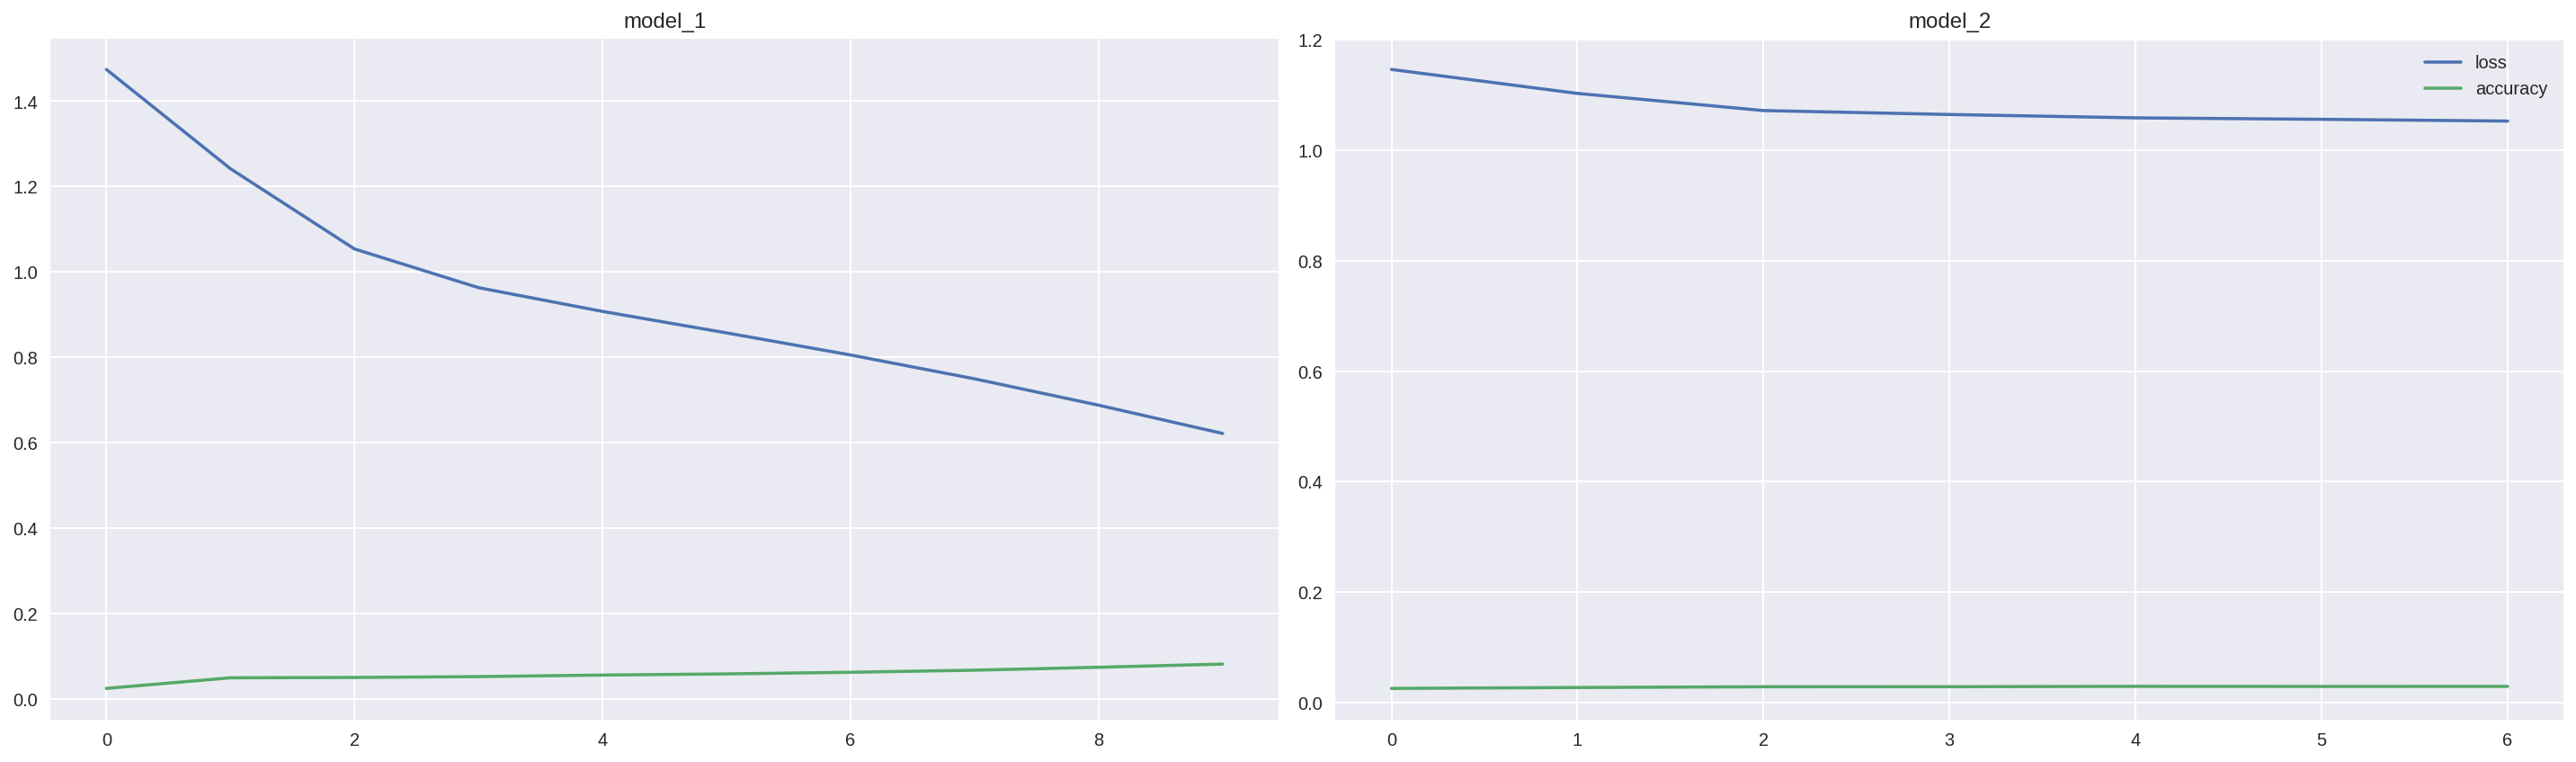

In [69]:
fig, ax = plt.subplots(ncols=2, figsize=(20,6))
ax[0].plot(history_1.history['loss'], label='loss')
ax[0].plot(history_1.history['accuracy'], label='accuracy')
ax[0].set_title("model_1")

ax[1].plot(history_2.history['loss'], label='loss')
ax[1].plot(history_2.history['accuracy'], label='accuracy')
ax[1].set_title("model_2")
plt.legend()
plt.tight_layout()
plt.show()


### **5-6. 모델 평가**

In [114]:
def decoder_inference(model,sentence):
    sentence = preprocess_sentence(sentence)

    # 토큰 추가
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 예측한 출력 시퀀스를 저장하는 변수, 초기 값은 시작 토큰으로 저장
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 종료 토큰이 나오면 반복문 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들을 output_sequence에 추가하고 추가된 단어들은 다시 디코더의 입력으로 할당
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [116]:
def sentence_generation(model, sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(model, sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [117]:

sentence_generation(model_1,'안녕하세요?')

입력 : 안녕하세요?
출력 : 밖에 문화모아 문화밖에 밖에 문화기억의 문화던게 기억의 파낼 외국어남았네요외국어남았네요외국어남았네요낼 외국어밖에 밖에 문화야겠다외국어남았네요외국어남았네요외국어파파파파파파파파파파


'밖에 문화모아 문화밖에 밖에 문화기억의 문화던게 기억의 파낼 외국어남았네요외국어남았네요외국어남았네요낼 외국어밖에 밖에 문화야겠다외국어남았네요외국어남았네요외국어파파파파파파파파파파'